In [125]:
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

# Load the dataset
file_path = "data/AMZN_historical_data.csv"
df = pd.read_csv(file_path)

# Display basic info and head of the data
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6846 entries, 0 to 6845
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6846 non-null   object 
 1   Open          6846 non-null   float64
 2   High          6846 non-null   float64
 3   Low           6846 non-null   float64
 4   Close         6846 non-null   float64
 5   Adj Close     6846 non-null   float64
 6   Volume        6846 non-null   int64  
 7   Dividends     6846 non-null   float64
 8   Stock Splits  6846 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 481.5+ KB


(None,
          Date      Open      High       Low     Close  Adj Close      Volume  \
 0  1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000   
 1  1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000   
 2  1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000   
 3  1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000   
 4  1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000   
 
    Dividends  Stock Splits  
 0        0.0           0.0  
 1        0.0           0.0  
 2        0.0           0.0  
 3        0.0           0.0  
 4        0.0           0.0  )

In [126]:
# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Calculate technical indicators using TA-Lib
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)

In [127]:
# MACD and Signal line
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['MACD_Signal'] = macdsignal

# Preview the last few rows to verify calculations
df[['Date', 'Close', 'SMA_20', 'SMA_50', 'RSI_14', 'MACD', 'MACD_Signal']].tail()


,Date,Close,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal
6841,2024-07-24,180.830002,192.8900,187.364001,37.221397,-1.342010,0.635114
6842,2024-07-25,179.850006,192.2020,187.229601,36.132394,-1.878483,0.132395
6843,2024-07-26,182.500000,191.4345,187.138200,41.146719,-2.065994,-0.307283
6844,2024-07-29,183.199997,190.9320,187.082400,42.432437,-2.133520,-0.672530
6845,2024-07-30,181.710007,190.1575,187.044000,40.408843,-2.280971,-0.994218


In [128]:
# --- 1. Simple Moving Averages (SMA) ---
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# --- 2. Relative Strength Index (RSI) ---
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# --- 3. MACD (12, 26 EMA) and Signal Line (9 EMA of MACD) ---
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Preview the result
df[['Date', 'Close', 'SMA_20', 'SMA_50', 'RSI_14', 'MACD', 'MACD_Signal']].tail()




,Date,Close,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal
6841,2024-07-24,180.830002,192.8900,187.364001,22.880276,-1.342010,0.635114
6842,2024-07-25,179.850006,192.2020,187.229601,15.812703,-1.878483,0.132395
6843,2024-07-26,182.500000,191.4345,187.138200,23.272844,-2.065994,-0.307283
6844,2024-07-29,183.199997,190.9320,187.082400,24.828434,-2.133520,-0.672530
6845,2024-07-30,181.710007,190.1575,187.044000,22.688822,-2.280971,-0.994218


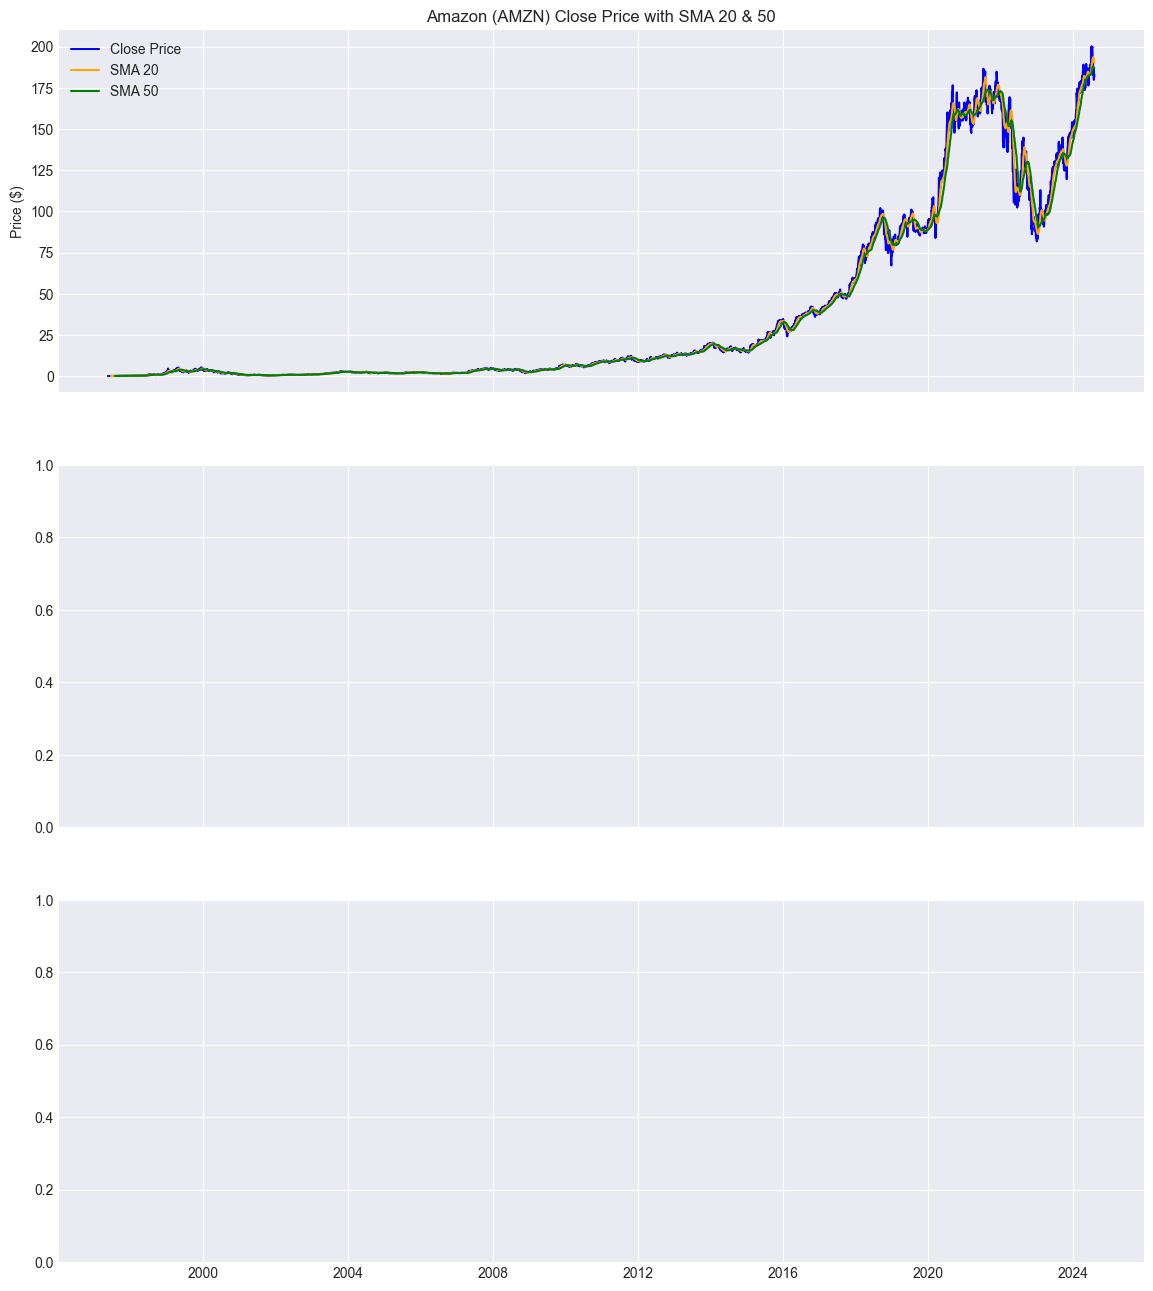

In [129]:
# Set up plots
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

# --- Plot 1: Close Price with SMA20 and SMA50 ---
axes[0].plot(df['Date'], df['Close'], label='Close Price', color='blue')
axes[0].plot(df['Date'], df['SMA_20'], label='SMA 20', color='orange')
axes[0].plot(df['Date'], df['SMA_50'], label='SMA 50', color='green')
axes[0].set_title('Amazon (AMZN) Close Price with SMA 20 & 50')
axes[0].set_ylabel('Price ($)')
axes[0].legend()


In [130]:
# --- Plot 2: RSI ---
axes[1].plot(df['Date'], df['RSI_14'], label='RSI (14)', color='purple')
axes[1].axhline(70, color='red', linestyle='--', alpha=0.7)
axes[1].axhline(30, color='green', linestyle='--', alpha=0.7)
axes[1].set_title('Relative Strength Index (RSI)')
axes[1].set_ylabel('RSI Value')
axes[1].legend()

# --- Plot 3: MACD ---
axes[2].plot(df['Date'], df['MACD'], label='MACD', color='black')
axes[2].plot(df['Date'], df['MACD_Signal'], label='Signal Line', color='red')
axes[2].set_title('MACD and Signal Line')
axes[2].set_ylabel('MACD Value')
axes[2].legend()

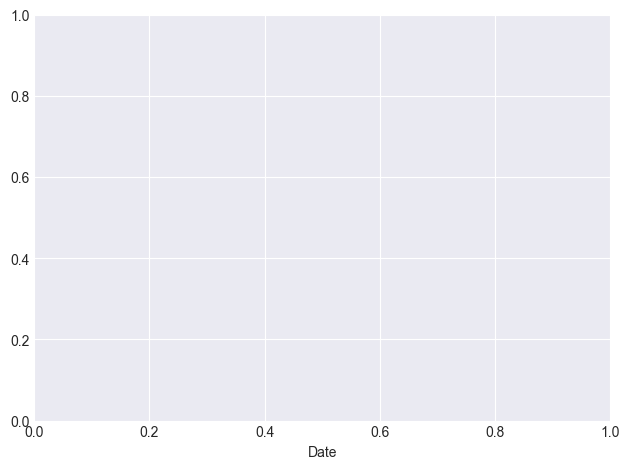

In [131]:
# Final layout tweaks
plt.xlabel('Date')
plt.tight_layout()
plt.show()

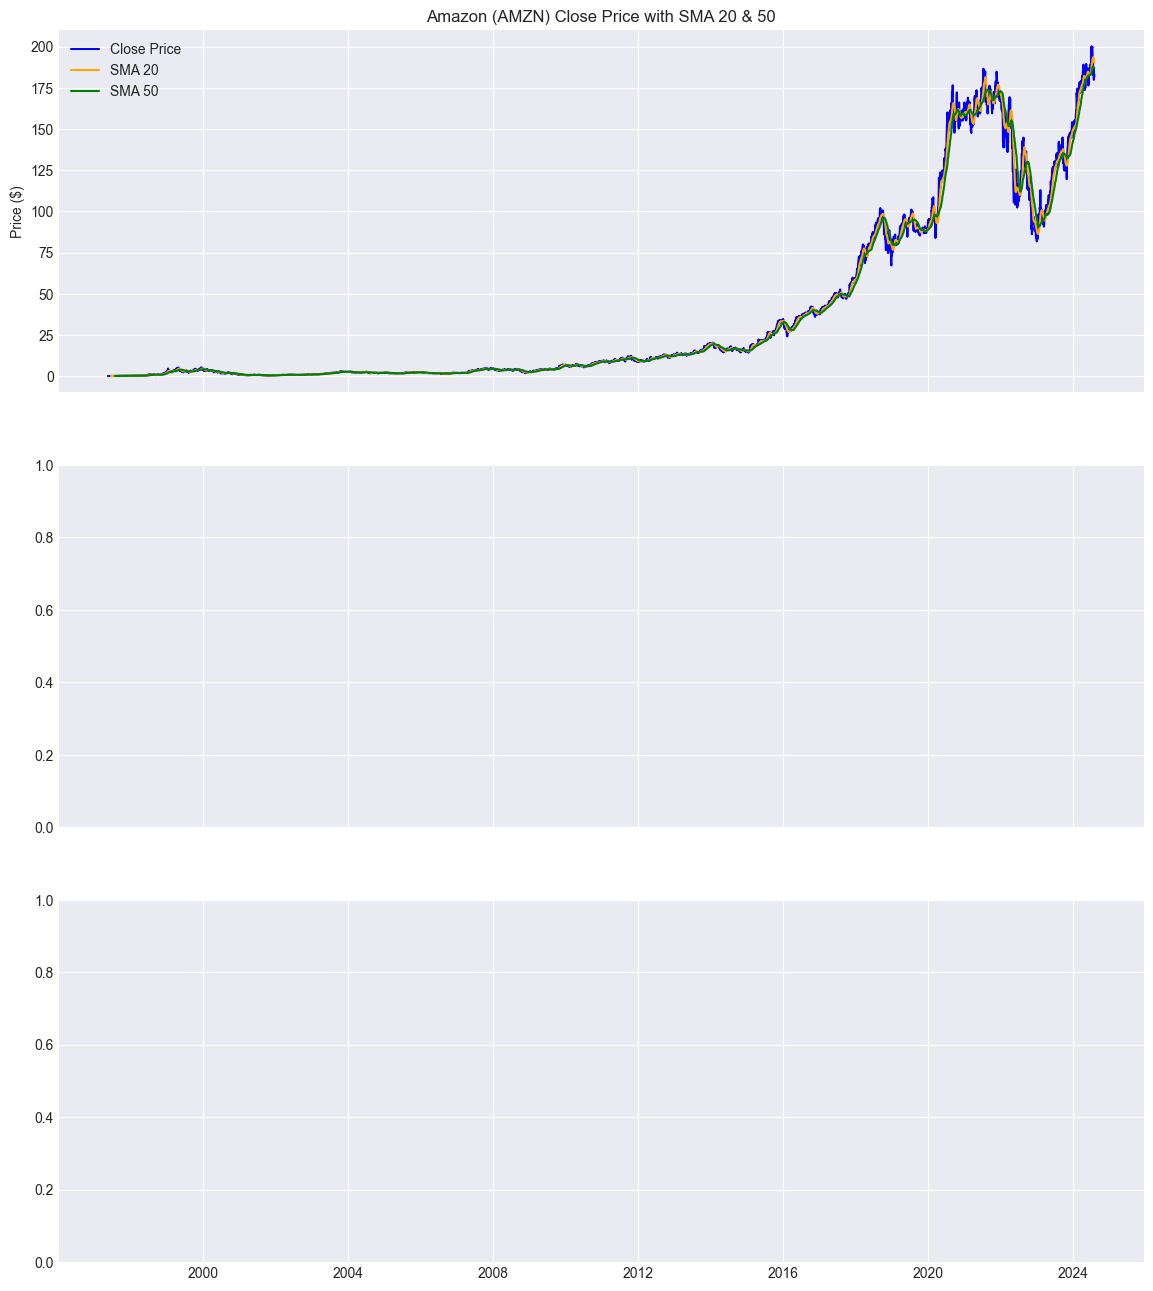

In [132]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

# Plot 1: Close Price + SMA20 + SMA50
axes[0].plot(df['Date'], df['Close'], label='Close Price', color='blue')
axes[0].plot(df['Date'], df['SMA_20'], label='SMA 20', color='orange')
axes[0].plot(df['Date'], df['SMA_50'], label='SMA 50', color='green')
axes[0].set_title('Amazon (AMZN) Close Price with SMA 20 & 50')
axes[0].set_ylabel('Price ($)')
axes[0].legend()

In [ ]:
# Plot 2: RSI
axes[1].plot(df['Date'], df['RSI_14'], label='RSI (14)', color='purple')
axes[1].axhline(70, color='red', linestyle='--', alpha=0.7)
axes[1].axhline(30, color='green', linestyle='--', alpha=0.7)
axes[1].set_title('Relative Strength Index (RSI)')
axes[1].set_ylabel('RSI Value')
axes[1].legend()
# Plot 3: MACD
axes[2].plot(df['Date'], df['MACD'], label='MACD', color='black')
axes[2].plot(df['Date'], df['MACD_Signal'], label='Signal Line', color='red')
axes[2].set_title('MACD and Signal Line')
axes[2].set_ylabel('MACD Value')
axes[2].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()